Nama : Amrul Fadhil Yofan

Dataset : https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data

Source : Kaggle

In [155]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,Embedding,Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Import Dataset dari Kaggle

In [2]:
!pip install -q kaggle

In [3]:
# Upload kaggle.json secara manual
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amrulfy","key":"8ec629e82333ebf8f0418507351abeda"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
# Download dataset
!kaggle datasets download -d emmanuelfwerr/london-weather-data

  0% 0.00/226k [00:00<?, ?B/s]
100% 226k/226k [00:00<00:00, 70.9MB/s]


In [6]:
# Unzip dan lihat list dataset
!mkdir weather
!unzip london-weather-data.zip -d weather
!ls weather

Archive:  london-weather-data.zip
  inflating: weather/london_weather.csv  
london_weather.csv


In [7]:
# Import data
df = pd.read_csv('weather/london_weather.csv')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


## Analisis Data dan Cleaning Data

In [9]:
# Cek ukuran data
df.shape

(15341, 10)

Tujuan submission ini adalah untuk memprediksi suhu rata-rata cuaca di kota London (tahun 1979-2020) dengan menggunakan time series.

In [10]:
# Cek data kosong
df.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [11]:
# Reduksi data (Mengambil fitur yang dibutuhkan)
df_red = df[["date","max_temp","min_temp","mean_temp"]]
df_red

,date,max_temp,min_temp,mean_temp
0,19790101,2.3,-7.5,-4.1
1,19790102,1.6,-7.5,-2.6
2,19790103,1.3,-7.2,-2.8
3,19790104,-0.3,-6.5,-2.6
4,19790105,5.6,-1.4,-0.8
...,...,...,...,...
15336,20201227,7.5,7.6,7.5
15337,20201228,3.6,-1.3,1.1
15338,20201229,4.1,1.1,2.6
15339,20201230,5.6,-0.1,2.7


In [12]:
df_red['date'] = df_red['date'].astype(str)
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       15341 non-null  object 
 1   max_temp   15335 non-null  float64
 2   min_temp   15339 non-null  float64
 3   mean_temp  15305 non-null  float64
dtypes: float64(3), object(1)
memory usage: 479.5+ KB


<ipython-input-12-9349e2f44b93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['date'] = df_red['date'].astype(str)


In [13]:
# Mengubah tipe data pada fitur "date" menjadi datetime
df_red['date'] =  df_red['date'].str.strip().str[0:4] + '-' + df_red['date'].str.strip().str[4:6] + '-' + df_red['date'].str.strip().str[6:8]

df_red["date"] = pd.to_datetime(df_red["date"])
df_red

<ipython-input-13-4af3f033d776>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['date'] =  df_red['date'].str.strip().str[0:4] + '-' + df_red['date'].str.strip().str[4:6] + '-' + df_red['date'].str.strip().str[6:8]
<ipython-input-13-4af3f033d776>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red["date"] = pd.to_datetime(df_red["date"])


,date,max_temp,min_temp,mean_temp
0,1979-01-01,2.3,-7.5,-4.1
1,1979-01-02,1.6,-7.5,-2.6
2,1979-01-03,1.3,-7.2,-2.8
3,1979-01-04,-0.3,-6.5,-2.6
4,1979-01-05,5.6,-1.4,-0.8
...,...,...,...,...
15336,2020-12-27,7.5,7.6,7.5
15337,2020-12-28,3.6,-1.3,1.1
15338,2020-12-29,4.1,1.1,2.6
15339,2020-12-30,5.6,-0.1,2.7


In [14]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15341 non-null  datetime64[ns]
 1   max_temp   15335 non-null  float64       
 2   min_temp   15339 non-null  float64       
 3   mean_temp  15305 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 479.5 KB


In [15]:
# Cek baris yang memuat data kosong
min_temp_empty = df_red[df_red['min_temp'].isna()]
max_temp_empty = df_red[df_red['max_temp'].isna()]
min_temp_empty

,date,max_temp,min_temp,mean_temp
15101,2020-05-06,NaN,NaN,NaN
15131,2020-06-05,16.5,NaN,NaN


In [16]:
max_temp_empty

,date,max_temp,min_temp,mean_temp
15010,2020-02-05,NaN,2.4,NaN
15044,2020-03-10,NaN,6.4,NaN
15101,2020-05-06,NaN,NaN,NaN
15172,2020-07-16,NaN,16.1,NaN
15197,2020-08-10,NaN,18.7,NaN
15256,2020-10-08,NaN,12.2,NaN


In [17]:
# Mengisi data min_temp dan max_temp kosong dengan menggunakan rata-rata hari sebelumnya dan sesudahnya
for i in range(len(df_red)):
  if df_red['min_temp'].isna()[i] == True:
    df_red['min_temp'][i] =  (df_red['min_temp'][i+1] + df_red['min_temp'][i-1])/2

for i in range(len(df_red)):
  if df_red['max_temp'].isna()[i] == True:
    df_red['max_temp'][i] =  (df_red['max_temp'][i+1] + df_red['max_temp'][i-1])/2

<ipython-input-17-2ea9beeaaa07>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['min_temp'][i] =  (df_red['min_temp'][i+1] + df_red['min_temp'][i-1])/2
<ipython-input-17-2ea9beeaaa07>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['max_temp'][i] =  (df_red['max_temp'][i+1] + df_red['max_temp'][i-1])/2


In [18]:
# Mengisi data mean_temp dengan menghitung rata-rata min_temp dan max_temp
for i in range(len(df_red)):
  if df_red['mean_temp'].isna()[i] == True:
    df_red['mean_temp'][i] =  (df_red['min_temp'][i] + df_red['max_temp'][i])/2

df_red.info()

<ipython-input-18-f1566e95e049>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['mean_temp'][i] =  (df_red['min_temp'][i] + df_red['max_temp'][i])/2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15341 non-null  datetime64[ns]
 1   max_temp   15341 non-null  float64       
 2   min_temp   15341 non-null  float64       
 3   mean_temp  15341 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 479.5 KB


In [163]:
# Dipilih mean_temp untuk proses modelling selanjutnya
new_df = df_red.drop(columns=['min_temp','max_temp'])
# new_df = new_df[731:]
new_df

,date,mean_temp
0,1979-01-01,-4.1
1,1979-01-02,-2.6
2,1979-01-03,-2.8
3,1979-01-04,-2.6
4,1979-01-05,-0.8
...,...,...
15336,2020-12-27,7.5
15337,2020-12-28,1.1
15338,2020-12-29,2.6
15339,2020-12-30,2.7


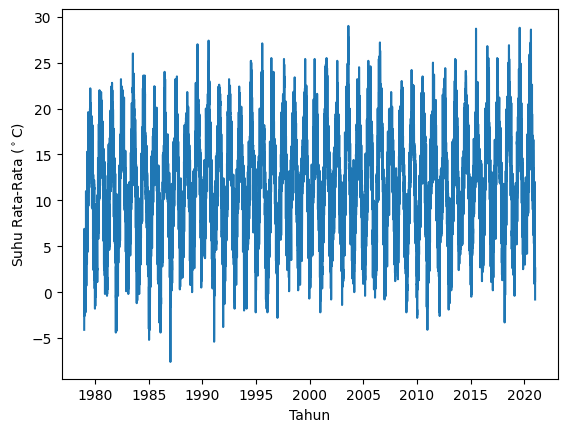

In [164]:
plt.plot(new_df['date'], new_df['mean_temp'])
plt.xlabel('Tahun')
plt.ylabel('Suhu Rata-Rata ($^\circ$C)')
plt.show()

## Normalisasi dan Split Data

In [165]:
set_df = new_df.set_index('date')
set_df

,mean_temp
date,
1979-01-01,-4.1
1979-01-02,-2.6
1979-01-03,-2.8
1979-01-04,-2.6
1979-01-05,-0.8
...,...
2020-12-27,7.5
2020-12-28,1.1
2020-12-29,2.6


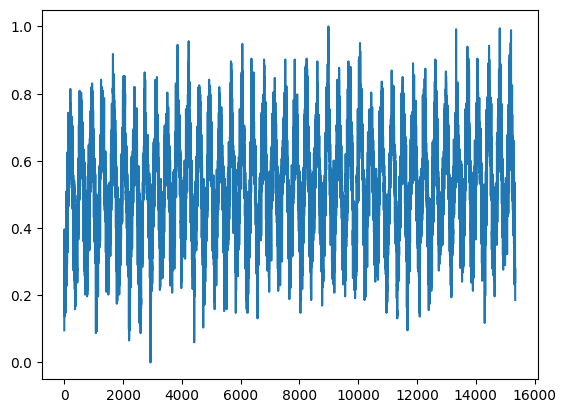

In [166]:
# Normalisasi
scaler = MinMaxScaler(feature_range = (0, 1))
df_scale = scaler.fit_transform(set_df)
plt.plot(df_scale)

In [167]:
#Split data
train_size = int(len(df_scale)*0.8)
test_size = len(df_scale) - train_size
x_data, y_data = df_scale[0: train_size, :], df_scale[train_size: len(df_scale), :1]
print(train_size, test_size)

def dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

x_train, y_train = dataset(x_data, 64)
x_test, y_test = dataset(y_data, 64)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

12272 3069


In [168]:
print(x_train)

[[[0.09562842]
  [0.13661202]
  [0.13114754]
  ...
  [0.50819672]
  [0.40983607]
  [0.35519126]]

 [[0.13661202]
  [0.13114754]
  [0.13661202]
  ...
  [0.40983607]
  [0.35519126]
  [0.37978142]]

 [[0.13114754]
  [0.13661202]
  [0.18579235]
  ...
  [0.35519126]
  [0.37978142]
  [0.36065574]]

 ...

 [[0.66666667]
  [0.67486339]
  [0.64480874]
  ...
  [0.63934426]
  [0.70491803]
  [0.72404372]]

 [[0.67486339]
  [0.64480874]
  [0.53005464]
  ...
  [0.70491803]
  [0.72404372]
  [0.69672131]]

 [[0.64480874]
  [0.53005464]
  [0.51092896]
  ...
  [0.72404372]
  [0.69672131]
  [0.69398907]]]


In [169]:
print(x_test)

[[[0.63661202]
  [0.73224044]
  [0.74863388]
  ...
  [0.46174863]
  [0.47814208]
  [0.52185792]]

 [[0.73224044]
  [0.74863388]
  [0.77868852]
  ...
  [0.47814208]
  [0.52185792]
  [0.53005464]]

 [[0.74863388]
  [0.77868852]
  [0.73770492]
  ...
  [0.52185792]
  [0.53005464]
  [0.54371585]]

 ...

 [[0.4863388 ]
  [0.48087432]
  [0.46721311]
  ...
  [0.27868852]
  [0.34153005]
  [0.41256831]]

 [[0.48087432]
  [0.46721311]
  [0.50546448]
  ...
  [0.34153005]
  [0.41256831]
  [0.23770492]]

 [[0.46721311]
  [0.50546448]
  [0.51092896]
  ...
  [0.41256831]
  [0.23770492]
  [0.27868852]]]


In [170]:
print(y_train)
print(y_test)

[0.37978142 0.36065574 0.36065574 ... 0.69672131 0.69398907 0.67213115]
[0.53005464 0.54371585 0.54371585 ... 0.23770492 0.27868852 0.28142077]


## Modelling

In [181]:
model = Sequential([
    LSTM(128, return_sequences = True, input_shape=(64, 1)),
    LSTM(64, return_sequences = True),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.3),
    Dense(8, activation="relu"),
    Dropout(0.2),
    Dense(1, activation='linear')
])

In [182]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [183]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold_mae = (df_scale.max() - df_scale.min()) * 10/100
    if(logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae):
      self.model.stop_training = True
      print("\n MAE < 10% skala data sehingga iterasi dihentikan")
callbacks = myCallback()

In [184]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = 128, callbacks = callbacks, verbose = 1)

Epoch 1/50
96/96 [==============================] - 61s 553ms/step - loss: 0.0654 - mae: 0.3036 - val_loss: 0.0176 - val_mae: 0.1506
Epoch 2/50
96/96 [==============================] - 50s 526ms/step - loss: 0.0143 - mae: 0.1327 - val_loss: 0.0127 - val_mae: 0.1309
Epoch 3/50
96/96 [==============================] - 50s 517ms/step - loss: 0.0115 - mae: 0.1196 - val_loss: 0.0120 - val_mae: 0.1279
Epoch 4/50
96/96 [==============================] - 50s 521ms/step - loss: 0.0102 - mae: 0.1132 - val_loss: 0.0110 - val_mae: 0.1228
Epoch 5/50
96/96 [==============================] - 53s 550ms/step - loss: 0.0095 - mae: 0.1096 - val_loss: 0.0101 - val_mae: 0.1169
Epoch 6/50
96/96 [==============================] - 51s 532ms/step - loss: 0.0091 - mae: 0.1069 - val_loss: 0.0093 - val_mae: 0.1121
Epoch 7/50
96/96 [==============================] - 51s 534ms/step - loss: 0.0089 - mae: 0.1057 - val_loss: 0.0082 - val_mae: 0.1046
Epoch 8/50
96/96 [==============================] - 51s 532ms/step - 

In [185]:
# Grafik Loss dan Accuracy

train_accuracy = history.history['mae']
val_accuracy = history.history['val_mae']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

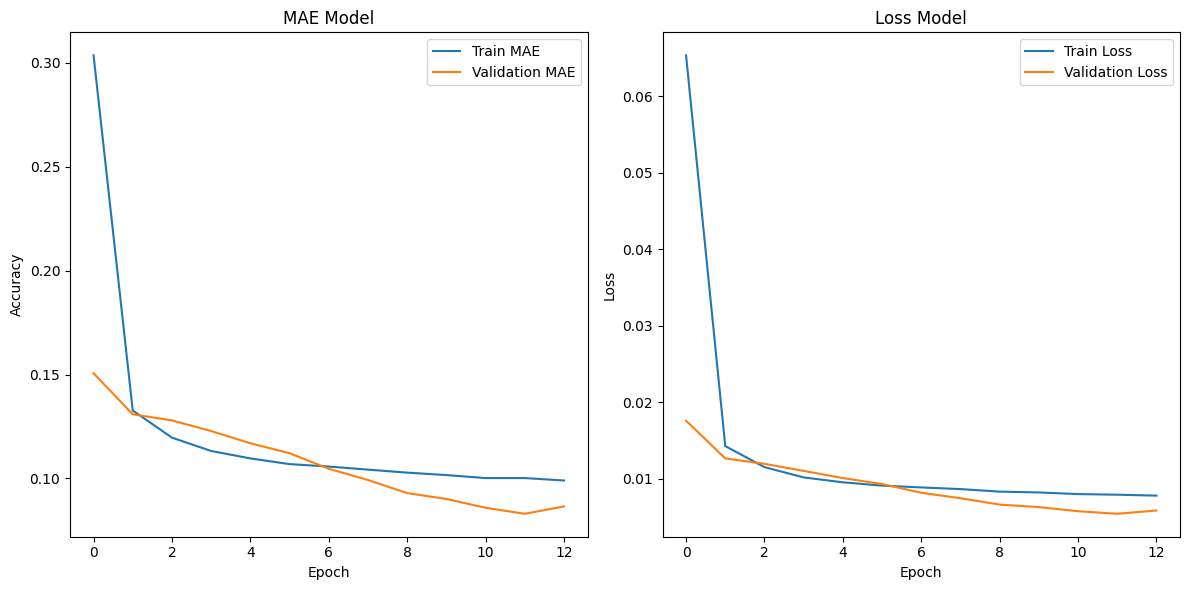

In [186]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy
axes[0].plot(train_accuracy, label='Train MAE')
axes[0].plot(val_accuracy, label='Validation MAE')
axes[0].set_title('MAE Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')

# Loss
axes[1].plot(train_loss, label='Train Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()